In [1]:
import tensorflow as tf
from IPython.display import clear_output
import matplotlib.pyplot as plt
import glob
import numpy as np
import os
import json
import pandas as pd
import cv2
from PIL import Image
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.utils import normalize
print(tf.__version__)


2.16.1


In [2]:
# Load and parse the JSON data
with open('Training/kili170602.json') as f:
    data = json.load(f)

# Initialize the output directory
output_dir = 'Training/Masks'

# Process each job in the list
for i, job in enumerate(data):
    # Check if the 'latestLabel' field is not None
    if job['latestLabel'] is not None and 'jsonResponse' in job['latestLabel'] and 'OBJECT_DETECTION_JOB' in job['latestLabel']['jsonResponse']:

        # Get the annotations for water
        annotations_polygons = job['latestLabel']['jsonResponse']['OBJECT_DETECTION_JOB']['annotations']

        # Create an empty mask
        height, width = 700, 440  # Use the size of the images
        mask = np.zeros((height, width), dtype=np.uint8)

        # Process each annotation
        for j, annotation_poly in enumerate(annotations_polygons):
            # Get the list of bounding polygons
            bounding_polygons = annotation_poly.get('boundingPoly', [])

            # Process each bounding polygon
            for bounding_poly in bounding_polygons:
                # Get the normalized vertices for this bounding polygon
                normalized_vertices = bounding_poly.get('normalizedVertices', [])

                # Convert the normalized vertices to pixel coordinates
                polygon = np.array([
                    [int(point['x'] * width), int(point['y'] * height)]
                    for point in normalized_vertices
                ])

                # Fill in the polygon with color=1 for CNN
                cv2.fillPoly(mask, [polygon], 1)

        # Save the mask to a file
        filename = job["externalId"].split('.')[0] + ".png"
        file_path = os.path.join(output_dir, filename)
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        cv2.imwrite(file_path, mask)


In [3]:
image_directory = "Training/Images/"
mask_directory = "Training/Masks/"

image_dataset = []
mask_dataset = []

images = sorted(os.listdir(image_directory))

# Append loop
for i, image_name in enumerate(images):
    if (image_name.split('.')[1] == 'png'):
        # read and process image
        image = cv2.imread(image_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((432, 688))
        image_dataset.append(np.array(image))

        # read and process corresponding mask
        mask = cv2.imread(mask_directory+image_name, 0)
        mask = Image.fromarray(mask)
        mask = mask.resize((432, 688))
        mask_dataset.append(np.array(mask))

print(np.shape(image_dataset))
print(np.shape(mask_dataset))
#print(mask)
#print(images)

(492, 688, 432)
(492, 688, 432)


0


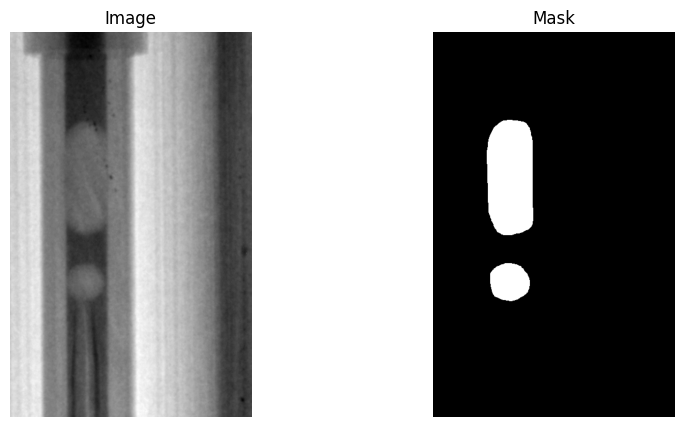

1


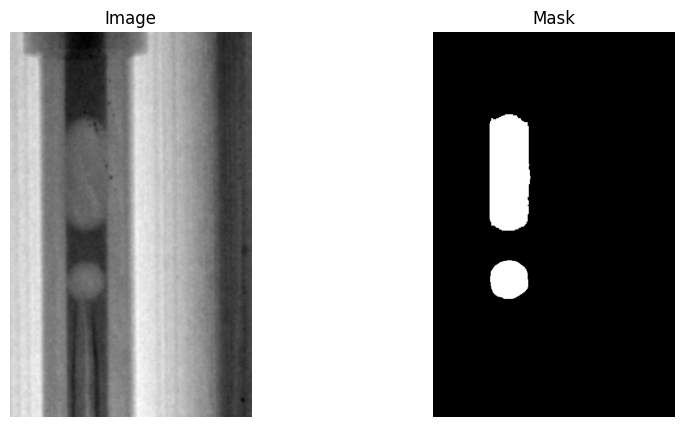

2


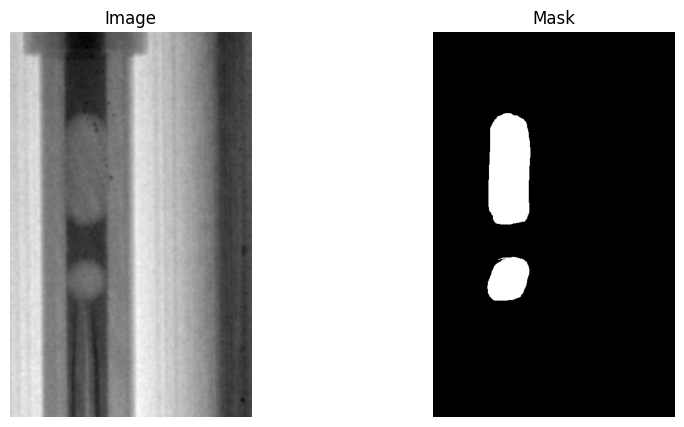

3


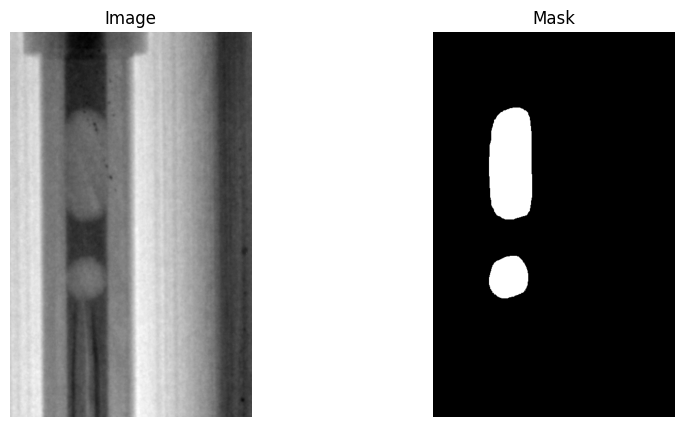

4


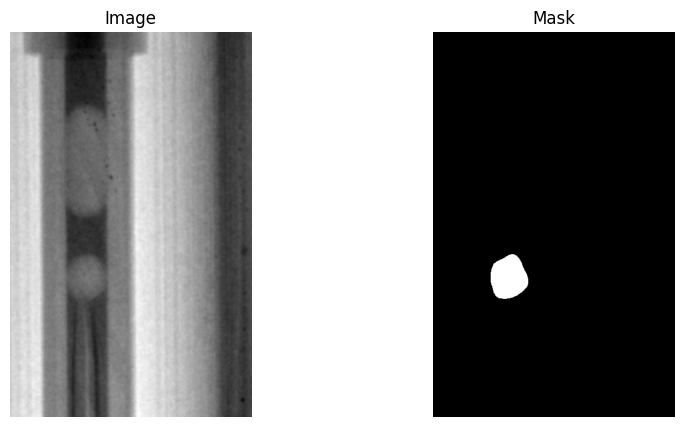

In [4]:
def display_images_and_masks(images, masks, num_samples=5):
    for i in range(num_samples):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(images[i], cmap='gray')
        plt.title("Image")
        plt.axis("off")
        print(i)
        plt.subplot(1, 2, 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title("Mask")
        plt.axis("off")

        plt.show()

# Display the images and masks
display_images_and_masks(image_dataset, mask_dataset)#


In [5]:
#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#Do not normalize masks, just rescale to 0 to 1.
#mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.
mask_dataset = np.expand_dims(np.array(mask_dataset), 3)

print(np.shape(image_dataset))
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

(492, 688, 432, 1)


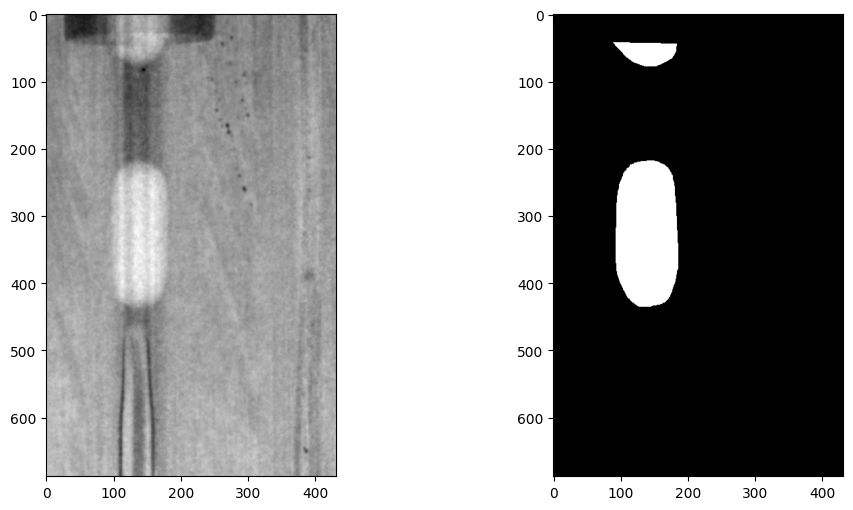

In [6]:
#Sanity check, view few mages
import random
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (688, 432)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (688, 432)), cmap='gray')
plt.show()


In [7]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model


In [8]:
# IMG_HEIGHT = image_dataset.shape[1]
# IMG_WIDTH  = image_dataset.shape[2]
# IMG_CHANNELS = image_dataset.shape[3]

IMG_HEIGHT = 688
IMG_WIDTH  = 432
IMG_CHANNELS = 1

def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 688, 432,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 688, 432,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 688, 432,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 688, 432,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 344, 216,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 344, 216,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 344, 216,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 344, 216,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 172, 108,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 172, 108,  │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 172, 108,  │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 172, 108,  │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 86, 54,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 86, 54,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 86, 54,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 86, 54,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 43, 27,    │          0 │ conv2d_7[0][0]  

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#If starting with pre-trained weights.
#model.load_weights('/content/drive/MyDrive/Coalb_Notebooks/epochs50.hdf5')

history = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    shuffle=False)

model.save('TF/Training/E50.hdf5')

Epoch 1/50


I0000 00:00:1719752140.313927   21504 service.cc:145] XLA service 0x7f574c00ae90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719752140.313995   21504 service.cc:153]   StreamExecutor device (0): Quadro P5000, Compute Capability 6.1
2024-06-30 12:56:25.258180: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[16,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,32,688,432]{3,2,1,0}, f32[16,16,688,432]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-06-30 12:56:26.103770: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.845750758s
Trying algorithm eng0{} for conv (f32[16

28/28 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.9324 - loss: 0.4456 - val_accuracy: 0.9348 - val_loss: 0.3206
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 447ms/step - accuracy: 0.9333 - loss: 0.2608 - val_accuracy: 0.9348 - val_loss: 0.3493
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 447ms/step - accuracy: 0.9333 - loss: 0.2315 - val_accuracy: 0.9348 - val_loss: 0.2433
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step - accuracy: 0.9333 - loss: 0.1712 - val_accuracy: 0.9348 - val_loss: 0.2104
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 450ms/step - accuracy: 0.9333 - loss: 0.1318 - val_accuracy: 0.9348 - val_loss: 0.1090
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 451ms/step - accuracy: 0.9333 - loss: 0.1034 - val_accuracy: 0.9348 - val_loss: 0.0831
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 450ms/step - accuracy: 0.9493 - loss: 0.0753 - val_accuracy: 0.9819 - val_loss: 0.0677
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 451ms/step - accuracy: 0.9796 - loss: 0.0675 - val_accuracy: 0.9809 

2024-06-30 13:09:20.688497: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,16,688,432]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,688,432]{3,2,1,0}, f32[16,32,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-06-30 13:09:21.510322: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.82197491s
Trying algorithm eng0{} for conv (f32[32,16,688,432]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,688,432]{3,2,1,0}, f32[16,32,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wa

1/2 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step - accuracy: 0.9799 - loss: 0.0618

2024-06-30 13:09:37.937062: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[18,16,688,432]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,32,688,432]{3,2,1,0}, f32[16,32,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-06-30 13:09:37.959943: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.023051733s
Trying algorithm eng0{} for conv (f32[18,16,688,432]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,32,688,432]{3,2,1,0}, f32[16,32,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","w

2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 16s/step - accuracy: 0.9805 - loss: 0.0574
Accuracy =  98.07484149932861 %


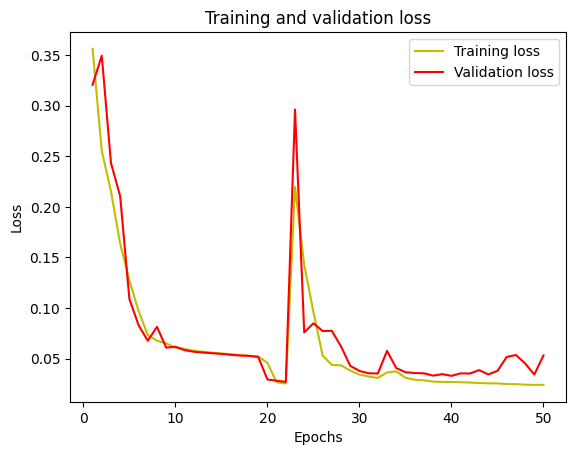

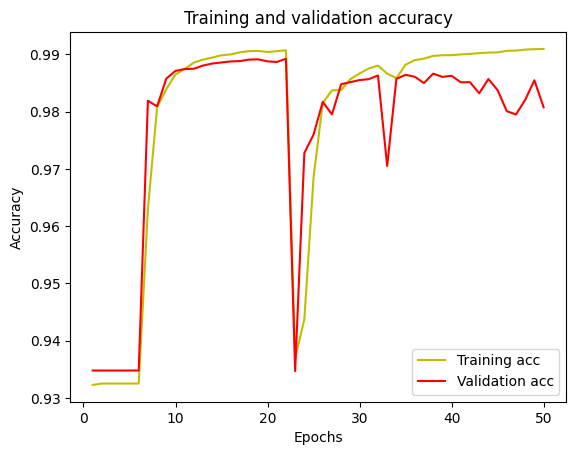

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
IoU socre is:  0.7321864193855792


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 688, 432,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 688, 432,  │        160 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 688, 432,  │          0 │ conv2d_19[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 688, 432,  │      2,320 │ dropout_9[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 344, 216,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 344, 216,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 344, 216,  │          0 │ conv2d_21[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 344, 216,  │      9,248 │ dropout_10[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 172, 108,  │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 172, 108,  │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 172, 108,  │          0 │ conv2d_23[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 172, 108,  │     36,928 │ dropout_11[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 86, 54,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 86, 54,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 86, 54,    │          0 │ conv2d_25[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 86, 54,    │    147,584 │ dropout_12[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 43, 27,    │          0 │ conv2d_26[0][0] 

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


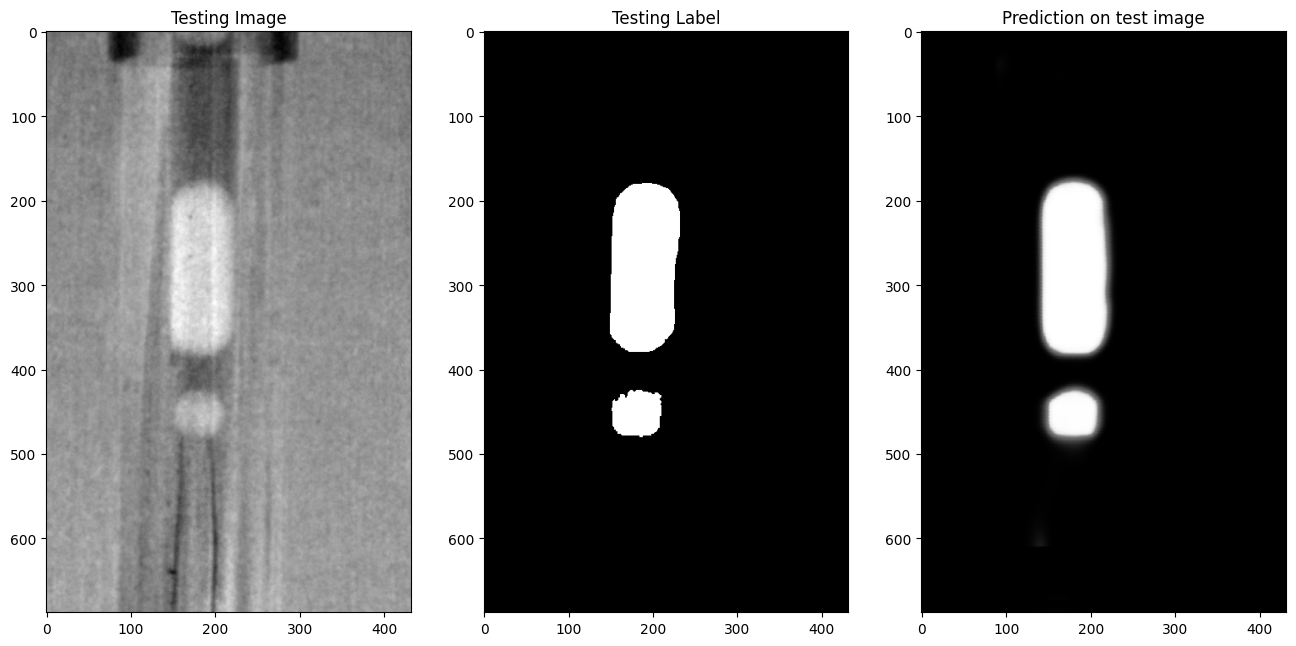

In [10]:
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#acc = history.history['acc']
acc = history.history['accuracy']
#val_acc = history.history['val_acc']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)




#Predict on a few images
model = get_model()
model.load_weights('TF/Training/E50.hdf5')


test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)

#prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
prediction = model.predict(test_img_input)[0, :, :, 0]

plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(132)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(133)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')




#plt.subplot(234)
#plt.imshow(np.reshape(test_img_other_input, (688, 432)), cmap='gray')
#plt.subplot(235)
#plt.imshow(np.reshape(prediction_other, (688, 432)), cmap='gray')
#plt.show()

#plt.imsave('input.jpg', test_img[:,:,0], cmap='gray')
#plt.imsave('data/results/output2.jpg', prediction_other, cmap='gray')






In [ ]:
# Function to normalize images
#def normalize(img, axis):
#    return (img - img.min()) / (img.max() - img.min())

# Load the model
model = get_model()
model.load_weights('/content/drive/MyDrive/Coalb_Notebooks/epochs50.hdf5')

# Select a random test image and its ground truth
test_img_number = random.randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]

# Normalize and prepare the test image for prediction
test_img_norm = test_img[:, :, 0][:, :, None]
test_img_input = np.expand_dims(test_img_norm, 0)

# Predict the mask for the test image
# prediction = (model.predict(test_img_input)[0, :, :, 0] > 0.2).astype(np.uint8)
prediction = model.predict(test_img_input)[0, :, :, 0]


test_dataset = []
# Load and preprocess an external image
test_img_other = cv2.imread('/content/drive/MyDrive/Coalb_Notebooks/Dataset/Images/Scan070602_00000000_0007.png', 0)

test_img_other = Image.fromarray(test_img_other)
test_img_other = test_img_other.resize((432, 688))
test_dataset.append(np.array(image))
test_dataset = np.expand_dims(normalize(np.array(test_dataset), axis=1),3)


print(np.shape(image_dataset))
print(np.shape(test_dataset))



#test_img_other_resized = test_img_other.resize((432, 688))
#test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other_resized), axis=1), 2)
#test_img_other_norm = test_img_other_norm[:, :, 0][:, :, None]
#test_img_other_input = np.expand_dims(test_img_other_norm, 0)

# Print shapes of the input images
print("Shape of test image input:", test_img_input.shape)
print("Shape of external image input:", test_img_other_input.shape)

# Predict the mask for the external image with a low threshold for watershed demo
prediction_other = (model.predict(test_dataset[0])[0, :, :, 0] > 0.5).astype(np.uint8)

# Visualize the results
plt.figure(figsize=(16, 8))

plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:, :, 0], cmap='gray')

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:, :, 0], cmap='gray')

plt.subplot(233)
plt.title('Prediction on Test Image')
plt.imshow(prediction, cmap='gray')

#plt.subplot(234)
#plt.title('External Image')
#plt.imshow(test_img_other_resized, cmap='gray')

#plt.subplot(235)
#plt.title('Prediction on External Image')
#plt.imshow(prediction_other, cmap='gray')


plt.subplot(234)
plt.imshow(np.reshape(test_dataset[0], (688, 432)), cmap='gray')
plt.subplot(235)
plt.imshow(np.reshape(prediction_other, (688, 432)), cmap='gray')
plt.show()

# Optionally, save the images
# plt.imsave('input.jpg', test_img[:,:,0], cmap='gray')
# plt.imsave('data/results/output2.jpg', prediction_other, cmap='gray')


In [ ]:
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#acc = history.history['acc']
acc = history.history['accuracy']
#val_acc = history.history['val_acc']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: ignored

In [11]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
IoU socre is:  0.7321864193855792


In [12]:

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'TF/Training/history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [ ]:

#Predict on a few images
model = get_model()
model.load_weights('/content/drive/MyDrive/Coalb_Notebooks/droplet_test_kili.hdf5')


test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

test_img_other = cv2.imread('/content/drive/MyDrive/Coalb_Notebooks/Dataset/Images/scan_00000000_0027.png', 0)
#test_img_other = cv2.imread('data/test_images/img8.tif', 0)
test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
test_img_other_input=np.expand_dims(test_img_other_norm, 0)

#Predict and threshold for values above 0.5 probability
#Change the probability threshold to low value (e.g. 0.05) for watershed demo.
prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.subplot(234)
plt.title('External Image')
plt.imshow(test_img_other, cmap='gray')
plt.subplot(235)
plt.title('Prediction of external Image')
plt.imshow(prediction_other, cmap='gray')
plt.show()

#plt.imsave('input.jpg', test_img[:,:,0], cmap='gray')
#plt.imsave('data/results/output2.jpg', prediction_other, cmap='gray')




Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 688, 336, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 688, 336, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)           (None, 688, 336, 16  0           ['conv2d_38[0][0]']              
                                )                                                           

NameError: ignored

1/1 [==============================] - 0s 62ms/step


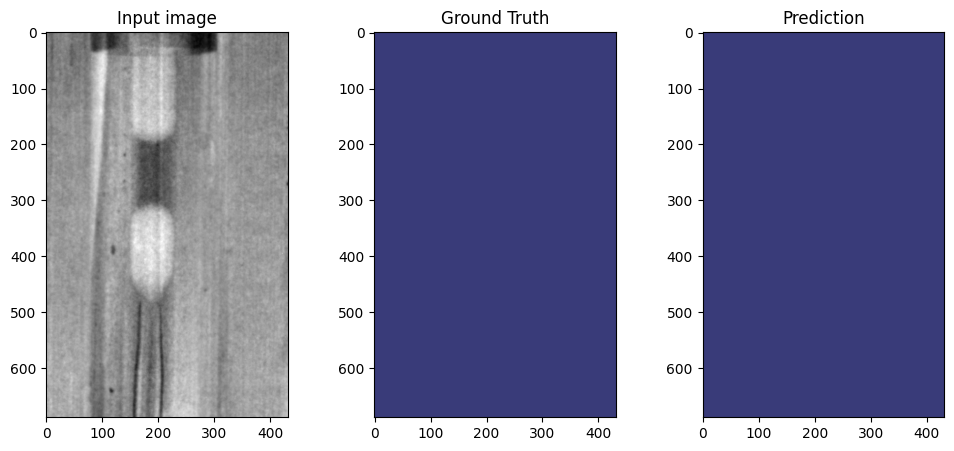

In [ ]:
def plot_sample(X, y, prediction=None):
    """Function to plot the results"""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.title("Input image")
    plt.imshow(X.squeeze(), cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(y.argmax(axis=-1), cmap='tab20b')

    if prediction is not None:
        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(prediction.argmax(axis=-1), cmap='tab20b')

    plt.show()

# Generate a random index for visualization
index = random.randint(0, X_test.shape[0])

# Predict the mask from the model
predicted_mask = model.predict(np.expand_dims(X_test[index], axis=0))

# Plot the original image, the mask, and the predicted mask
plot_sample(X_test[index], y_test[index], predicted_mask[0])